<a href="https://colab.research.google.com/github/SriSathwik1905/Diabetic-Retinopathy-VIT/blob/main/Vit_%2BECA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets tensorflow_hub --upgrade
!pip install scikit-learn matplotlib seaborn opencv-python

# 📦 1. Install and Import Required Libraries

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras import layers, models, optimizers
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 📁 2. Load Dataset using opendatasets (or manually if downloaded)

In [ ]:
import opendatasets as od
# Example: Replace with your actual Kaggle dataset URL
od.download('https://www.kaggle.com/datasets/kssanjaynithish03/retinal-fundus-images')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: srisathwikpadala
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/kssanjaynithish03/retinal-fundus-images


# 🧼 3. Preprocessing + Data Augmentation

In [ ]:
train_dir = r"/content/retinal-fundus-images/Retinal Fundus Images/train"
val_dir = r"/content/retinal-fundus-images/Retinal Fundus Images/val"
test_dir = r"/content/retinal-fundus-images/Retinal Fundus Images/test"

# Class mapping (ordinal)
dr_stage_mapping = {'3.Mild DR': 0, '4.Moderate DR': 1, '5.Severe DR': 2, '6.Proliferate DR': 3}
img_size = 224
batch_size = 32

# Updated data augmentation with more variability
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2
)

train_data = datagen.flow_from_directory(train_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode='sparse', classes=list(dr_stage_mapping.keys()))
val_data = datagen.flow_from_directory(val_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode='sparse', classes=list(dr_stage_mapping.keys()))
test_data = datagen.flow_from_directory(test_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode='sparse', shuffle=False, classes=list(dr_stage_mapping.keys()))

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_data.classes), y=train_data.classes)
class_weights_dict = dict(enumerate(class_weights))

Found 10206 images belonging to 4 classes.
Found 211 images belonging to 4 classes.
Found 516 images belonging to 4 classes.


# 🔧 4. Define CBAM and ECA Blocks

In [ ]:
def eca_block(input_feature, gamma=2, b=1):
    channel = input_feature.shape[-1]
    t = int(abs((np.log2(channel) + b) / gamma))
    k = t if t % 2 else t + 1
    avg_pool = layers.GlobalAveragePooling2D()(input_feature)
    avg_pool = layers.Reshape((-1, 1))(avg_pool)
    conv = layers.Conv1D(1, kernel_size=k, padding="same", use_bias=False)(avg_pool)
    conv = layers.Activation('sigmoid')(conv)
    conv = layers.Reshape((1, 1, channel))(conv)
    return layers.Multiply()([input_feature, conv])

# 🧠 5. Vision Transformer + CBAM + ECA Model

In [ ]:
import tensorflow_hub as hub

def build_model_eca_only():
    input_layer = layers.Input(shape=(img_size, img_size, 3))

    # Load Vision Transformer from TensorFlow Hub
    base_model = hub.KerasLayer("https://tfhub.dev/sayakpaul/vit_b16_fe/1", trainable=False)

    # Extract features
    x = layers.Lambda(lambda inputs: base_model(inputs, training=False))(input_layer)
    x = layers.Reshape((1, 1, -1))(x)  # Reshape for attention blocks

    # Apply ECA block
    x = eca_block(x)

    # Pool and classify
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    output_layer = layers.Dense(4, activation='softmax')(x)  # 4 output classes

    model = models.Model(inputs=input_layer, outputs=output_layer)
    return model

model_eca = build_model_eca_only()
model_eca.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_eca.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 768)            │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 768)      │              0 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 768)            │              0 │ reshape[0][0]          │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 768, 1)         │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 768, 1)         │              5 │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 768, 1)         │              0 │ conv1d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 1, 1, 768)      │              0 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 1, 1, 768)      │              0 │ reshape[0][0],         │
│                           │                        │                │ reshape_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 768)            │              0 │ multiply[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │         98,432 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 4)              │            516 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 98,953 (386.54 KB)

 Trainable params: 98,953 (386.54 KB)

 Non-trainable params: 0 (0.00 B)

# 🚀 6. Train the Model

In [ ]:
history_eca = model_eca.fit(train_data, validation_data=val_data, epochs=20, class_weight=class_weights_dict)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 276s 827ms/step - accuracy: 0.4708 - loss: 1.0956 - val_accuracy: 0.6256 - val_loss: 0.8353
Epoch 2/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 248s 775ms/step - accuracy: 0.5688 - loss: 0.8366 - val_accuracy: 0.6209 - val_loss: 0.8425
Epoch 3/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 243s 762ms/step - accuracy: 0.6118 - loss: 0.7614 - val_accuracy: 0.6445 - val_loss: 0.8386
Epoch 4/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 247s 773ms/step - accuracy: 0.6158 - loss: 0.7689 - val_accuracy: 0.6303 - val_loss: 0.7956
Epoch 5/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 249s 781ms/step - accuracy: 0.6285 - loss: 0.7195 - val_accuracy: 0.7014 - val_loss: 0.7044
Epoch 6/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 246s 772ms/step - accuracy: 0.6276 - loss: 0.7088 - val_accuracy: 0.6398 - val_loss: 0.7832
Epoch 7/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 246s 771ms/step - accuracy: 0.6428 - loss: 0.6930 - val_accuracy: 0.6919 - val_loss: 0.6341
Epoch 8/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 247s 773ms/step - accuracy: 0.6378 -

# 📊 7. Plot Training and Validation Curves

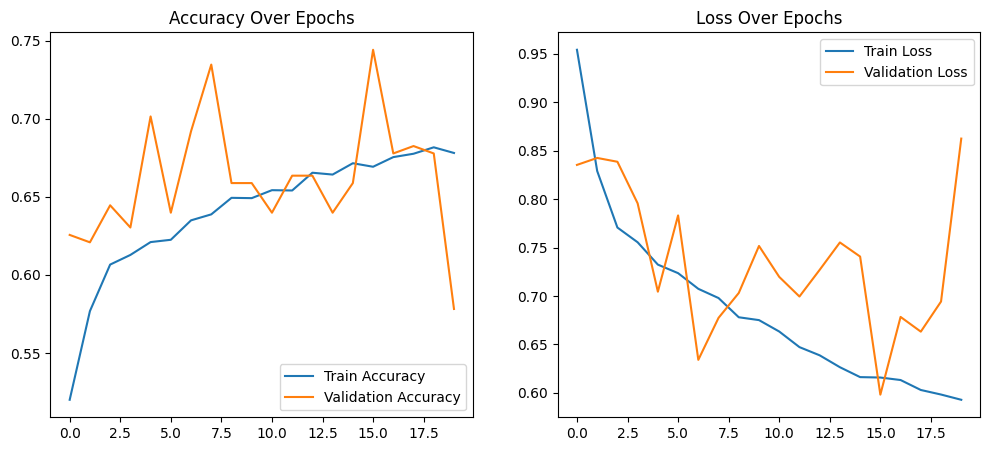

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_eca.history['accuracy'], label='Train Accuracy') # Access using history_eca.history['accuracy']
plt.plot(history_eca.history['val_accuracy'], label='Validation Accuracy') # Access using history_eca.history['val_accuracy']
plt.legend()
plt.title('Accuracy Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history_eca.history['loss'], label='Train Loss') # Access using history_eca.history['loss']
plt.plot(history_eca.history['val_loss'], label='Validation Loss') # Access using history_eca.history['val_loss']
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

# 📈 8. Evaluate Model (Confusion Matrix, Classification Report, ROC)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.81      0.54       102
           1       0.78      0.23      0.36       216
           2       0.49      0.64      0.55       107
           3       0.60      0.70      0.65        91

    accuracy                           0.52       516
   macro avg       0.57      0.60      0.53       516
weighted avg       0.61      0.52      0.49       516



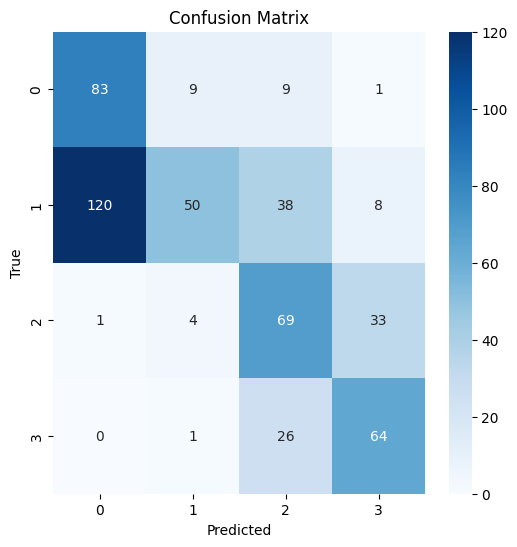

In [ ]:
preds = model_eca.predict(test_data) # Change model to model_eca
y_true = test_data.classes
y_pred = np.argmax(preds, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

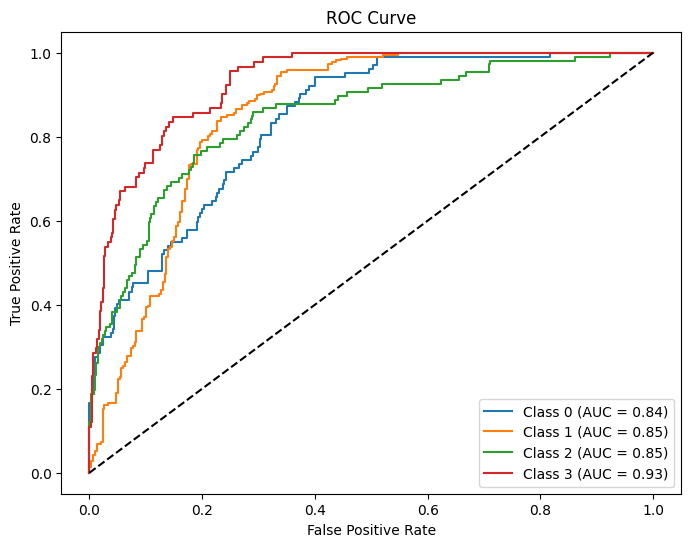

In [ ]:
fpr = {}
tpr = {}
roc_auc = {}

for i in range(4):  # Adjusted for 4 classes
    fpr[i], tpr[i], _ = roc_curve(y_true == i, preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(4):  # Adjusted for 4 classes
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


# 🔍 9. Grad-CAM Visualization

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


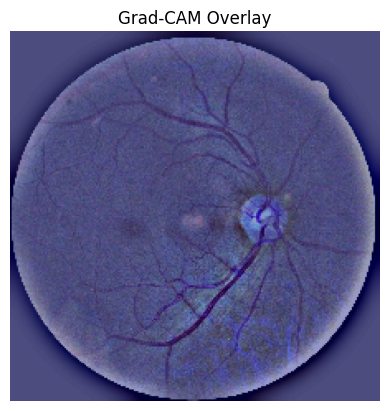

In [ ]:
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name="multiply"): # Changed the last convolutional layer name to 'multiply', which is the ECA block's output
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)[0]
    #pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)) # The previous line causing the error
    pooled_grads = tf.reduce_mean(grads, axis=(0,1)) # Updated line to reduce across the correct dimensions

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

# Example use on one image
img_path = test_data.filepaths[0]
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_size, img_size))
img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Changed 'model' to 'model_eca'
heatmap = make_gradcam_heatmap(img_array, model_eca)
plt.imshow(img)
plt.imshow(cv2.resize(heatmap, (224, 224)), cmap='jet', alpha=0.4)
plt.title("Grad-CAM Overlay")
plt.axis('off')
plt.show()